## Librerías

### Instalación

In [ ]:
!apt-get -qq install -y graphviz libgraphviz-dev
!pip install pygraphviz pypdf owlready2
!pip install pypdf
!pip install rdflib
!pip install -r requirements.txt

Selecting previously unselected package libgtk2.0-common.
(Reading database ... 125081 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.33-2ubuntu2.1_all.deb ...
Unpacking libgtk2.0-common (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libxdot4:amd64.
Preparing to unpack .../4-libxdot4_2.42.2-6ubuntu0.1_amd64.deb ...
Unpacking libxdot4:amd64 (2.42.2-6ubuntu0.1) ...
Selecting previousl

### Import

In [ ]:
import os
import ast
import pandas as pd
import numpy as np
from dotenv import load_dotenv

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.schema import HumanMessage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx

from owlready2 import *
import rdflib

from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from itertools import product

In [ ]:
pd.set_option('display.max_colwidth', None)  # Muestra todo el texto en las celdas
pd.set_option('display.max_rows', None)      # Muestra todas las filas
pd.set_option('display.max_columns', None)   # Muestra todas las columnas

## API key

In [ ]:
# Cargar API key
os.environ["OPENAI_API_KEY"] = "Acá va la apikey de OpenAI"

## Obtener Vectorstore

In [ ]:
def cargar_pdfs(carpeta):
    todos_los_documentos = []
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".pdf"):
            path = os.path.join(carpeta, archivo)
            try:
                loader = PyPDFLoader(path)
                documentos = loader.load()
                todos_los_documentos.extend(documentos)
            except Exception as e:
                print(f"Error al cargar {archivo}: {e}")
    return todos_los_documentos

In [ ]:
def dividir_texto(documentos):
    splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=500)
    return splitter.split_documents(documentos)

In [ ]:
def crear_vectorstore(chunks):
    embeddings = OpenAIEmbeddings()
    return FAISS.from_documents(chunks, embeddings)

## Obtención de Ontología

In [ ]:
def limpiar_owl(texto):
    # Encuentra el primer bloque que parece XML OWL válido
    match = re.search(r'<\?xml[^>]*\?>.*</rdf:RDF>', texto, re.DOTALL)
    if match:
        return match.group(0).strip()
    return texto.strip()  # Si no encuentra, retorna todo

In [ ]:
def extraer_ontologia(vectorstore, condicion, path_guardado="ontologia.owl"):
    query = f"""
    Eres un experto en medicina clínica y representación del conocimiento mediante ontologías OWL en RDF/XML.

    Condición a analizar: {condicion}

    Tu tarea es exclusivamente analizar los contenidos de los documentos disponibles en el corpus, sin utilizar conocimiento externo. El texto puede estar en distintos idiomas, traduce al inglés.

    Debes realizar las siguientes tareas:

    1. Extrae **todos los factores de riesgo** relacionados con {condicion}.

    2. Extrae **todos los síntomas y signos clínicos** que se pueden presentar como consecuencia de `{condicion}`. Considera tanto síntomas físicos como manifestaciones subjetivas reportadas por pacientes. Incluye manifestaciones locales, sistémicas o específicas, incluso si están redactadas en distintos estilos o sinónimos clínicos.

    3. Establece las siguientes relaciones ontológicas:
      - (Factor -> causa -> Condicion)
      - (Condicion -> provoca -> Sintoma)

    4. Modela una ontología en formato OWL (RDF/XML) que contenga:
      - Clases: `Factor`, `Condicion`, `Sintoma`
      - Individuos: uno por cada entidad clínica identificada.
      - Propiedades objetuales:
        - `causa` (dominio: Factor, rango: Condicion)
        - `provoca` (dominio: Condicion, rango: Sintoma)

    5. Nombra cada entidad con nombres normalizados en minúsculas, usando "_" en lugar de espacios. No repitas entidades. Mantén la simplicidad en el vocabulario.

    6. Asegúrate de que:
      - Se identifiquen al menos **uno o más factores de riesgo o antecedentes** relacionados con `{condicion}`.
      - Se incluyan **síntomas claros y clínicamente relevantes** asociados a `{condicion}`.

    7. Usa el namespace: `http://example.org/ontologia#` para todas las clases, propiedades e individuos.

    Tu respuesta debe:
    - Comenzar directamente con `<?xml`
    - Contener **únicamente contenido válido en formato OWL RDF/XML**
    - No incluir encabezados, comentarios, ni explicaciones
    - No utilizar comillas
    """

    qa = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(temperature=0, model_name="gpt-4o"),
        retriever = vectorstore.as_retriever(search_kwargs={"k": 999}),
        chain_type="stuff"
    )

    respuesta = qa.invoke({"query": query})
    texto_owl = respuesta['result'] if isinstance(respuesta, dict) else str(respuesta)

    texto_owl = limpiar_owl(texto_owl)

    with open(path_guardado, "w", encoding="utf-8") as f:
        f.write(texto_owl)

    print(f"✅ Ontología OWL guardada correctamente en: {path_guardado}")
    return path_guardado

In [ ]:
def leer_ontologia_owl(path_owl):
    g = rdflib.Graph()
    g.parse(path_owl, format='xml')

    ns = rdflib.Namespace("http://example.org/ontologia#")

    relaciones_FC = []  # Factor -> causa -> Condicion
    relaciones_CS = []  # Condicion -> provoca -> Sintoma

    # Identificar todas las relaciones de tipo causa
    for s, p, o in g.triples((None, ns.causa, None)):
        factor = rdflib.term.URIRef(s).split("#")[-1]
        condicion = rdflib.term.URIRef(o).split("#")[-1]
        relaciones_FC.append((factor, condicion))

    # Identificar todas las relaciones de tipo provoca
    for s, p, o in g.triples((None, ns.provoca, None)):
        condicion = rdflib.term.URIRef(s).split("#")[-1]
        sintoma = rdflib.term.URIRef(o).split("#")[-1]
        relaciones_CS.append((condicion, sintoma))

    if not relaciones_FC:
        print("⚠️ No se encontraron relaciones Factor -> causa -> Condición.")
    if not relaciones_CS:
        print("⚠️ No se encontraron relaciones Condición -> provoca -> Síntoma.")

    return relaciones_FC, relaciones_CS

## Red Bayesiana

In [ ]:
def extraer_probabilidad_condicion_dado_factor(vectorstore, factor, condicion):
    query = f"""
    Eres un experto en medicina.
    Considera el antecedente '{factor}' y la condición '{condicion}'.
    ¿Cuál es la probabilidad de que una persona desarrolle '{condicion}' dado que tiene '{factor}'?
    En caso de no encontrar la probabilidad de manera explicita, la debes inferir en base a la información contextual.
    Proporciónala sólo como un valor numérico entre 0 y 1, sin texto adicional.
    """
    # print("Buscando condicion dado antecedente: ", condicion, " dado ", antecedente)
    return _ejecutar_query_probabilidad(vectorstore, query)

In [ ]:
def extraer_probabilidad_sintoma_dado_condicion(vectorstore, condicion, sintoma):
    query = f"""
    Eres un experto en medicina.
    Considera la condición '{condicion}' y el síntoma '{sintoma}'.
    ¿Cuál es la probabilidad de que una persona presente el síntoma '{sintoma}' dado que tiene la condición '{condicion}'?
    En caso de no encontrar la probabilidad de manera explicita, la debes inferir en base a la información contextual.
    Proporciónala sólo como un valor numérico entre 0 y 1, sin texto adicional.
    """
    # print("Buscando sintoma dado condicion: ", sintoma, " dado ", condicion)
    return _ejecutar_query_probabilidad(vectorstore, query)

In [ ]:
def _ejecutar_query_probabilidad(vectorstore, query):
    qa = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(temperature=0, model_name="gpt-4o"),
        retriever=vectorstore.as_retriever(),
        chain_type="stuff"
    )
    respuesta = qa.invoke({"query": query})
    texto_respuesta = respuesta['result'] if isinstance(respuesta, dict) else str(respuesta)
    try:
        prob = float(texto_respuesta.strip())
        if 0 <= prob <= 1:
            return prob
        else:
            print(f"Probabilidad fuera de rango ej q: {prob}")
            return None
    except Exception as e:
        print(f"Error al convertir probabilidad: {e}")
        print(f"Respuesta recibida: {texto_respuesta}")
        return None

In [ ]:
def crear_red_bayesiana(relaciones_FC, relaciones_CS, vectorstore):
    modelo = DiscreteBayesianNetwork()
    relaciones_prob = {}

    # Añadir nodos y aristas: antecedentes -> condiciones
    for factor, condicion in relaciones_FC:
        modelo.add_nodes_from([factor, condicion])
        modelo.add_edge(factor, condicion)

    # Añadir nodos y aristas: condiciones -> síntomas
    for condicion, sintoma in relaciones_CS:
        modelo.add_nodes_from([condicion, sintoma])
        modelo.add_edge(condicion, sintoma)

    for nodo in modelo.nodes():
        padres = modelo.get_parents(nodo)

        if not padres:
            p = 0.5
            cpd = TabularCPD(variable=nodo, variable_card=2, values=[[1 - p], [p]])
            modelo.add_cpds(cpd)

        elif len(padres) == 1:
            padre = padres[0]
            if (padre, nodo) in relaciones_FC:
                p = extraer_probabilidad_condicion_dado_factor(vectorstore, padre, nodo) or 0.5
            elif (padre, nodo) in relaciones_CS:
                p = extraer_probabilidad_sintoma_dado_condicion(vectorstore, padre, nodo) or 0.5
            else:
                p = 0.5

            relaciones_prob[(padre, nodo)] = p

            # P(nodo=1 | padre) = p si padre=1, 0 si padre=0
            cpd = TabularCPD(
                variable=nodo,
                variable_card=2,
                values=[[p, 1 - p], [1 - p, p]],
                evidence=[padre],
                evidence_card=[2]
            )
            modelo.add_cpds(cpd)


        else:
            padres = list(padres)
            probs = {}
            for padre in padres:
                if (padre, nodo) in relaciones_FC:
                    p = extraer_probabilidad_condicion_dado_factor(vectorstore, padre, nodo) or 0.5
                elif (padre, nodo) in relaciones_CS:
                    p = extraer_probabilidad_sintoma_dado_condicion(vectorstore, padre, nodo) or 0.5
                else:
                    p = 0.5
                relaciones_prob[(padre, nodo)] = p
                probs[padre] = p

            combinaciones = list(product([0, 1], repeat=len(padres)))
            valores = [[], []]
            tabla_dict = {}

            for combinacion in combinaciones:
                p_falla = 1.0
                for i, padre_valor in enumerate(combinacion):
                    padre = padres[i]
                    if padre_valor == 1:
                        p_falla *= (1 - probs[padre])
                p_verdad = 1 - p_falla
                valores[0].append(1 - p_verdad)
                valores[1].append(p_verdad)
                tabla_dict[str(combinacion)] = {
                    0: round(1 - p_verdad, 4),
                    1: round(p_verdad, 4)
                }

            cpd = TabularCPD(
                variable=nodo,
                variable_card=2,
                values=valores,
                evidence=padres,
                evidence_card=[2] * len(padres)
            )
            modelo.add_cpds(cpd)

    modelo.check_model()
    return modelo, relaciones_prob

In [ ]:
def visualizar_red_bayesiana(modelo, relaciones_prob):
    G = nx.DiGraph()

    # Agregar nodos y aristas desde el modelo
    for nodo in modelo.nodes():
        for hijo in modelo.get_children(nodo):
            G.add_edge(nodo, hijo)

    # Posiciones del grafo
    try:
        pos = graphviz_layout(G, prog='dot')
    except:
        pos = nx.spring_layout(G, seed=16)

    plt.figure(figsize=(20, 12))

    # Clasificación de nodos por niveles
    nodos_factores = [n for n in modelo.nodes() if not modelo.get_parents(n)]
    nodos_sintoma = [n for n in modelo.nodes() if not modelo.get_children(n)]
    nodos_condicion = [n for n in modelo.nodes() if n not in nodos_factores and n not in nodos_sintoma]

    # Dibujar nodos con colores diferenciados
    nx.draw_networkx_nodes(G, pos, nodelist=nodos_factores, node_color="#ff9999", node_size=1600, edgecolors="black", label="Antecedentes")
    nx.draw_networkx_nodes(G, pos, nodelist=nodos_condicion, node_color="#99ccff", node_size=1600, edgecolors="black", label="Condiciones")
    nx.draw_networkx_nodes(G, pos, nodelist=nodos_sintoma, node_color="#99ff99", node_size=1600, edgecolors="black", label="Síntomas")

    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

    # Dibujar aristas
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray", width=2, arrows=True)

    # Anotar aristas con probabilidades
    edge_labels = {
        (u, v): f"{relaciones_prob.get((u, v), '?'):.2f}" for u, v in G.edges()
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Evaluación

In [ ]:
def solicitar_texto_clinico():
    print("Ingrese el texto clínico del paciente (finalice con ENTER):")
    return input(">> ")

In [ ]:
def extraer_items_desde_texto(texto, tipo, vectorstore, nodos_red):
    if tipo.lower() not in {"factor", "sintoma"}:
        raise ValueError("El tipo debe ser 'factor' o 'sintoma'.")

    nodos_lista = ", ".join(nodos_red)

    prompt = f"""
    Eres un experto en medicina.
    Del siguiente texto, solo identifica qué {tipo}s están presentes y especifica si su efecto sobre las condiciones clínicas es directo (lo potencia) o inverso (lo inhibe).

    Solo puedes seleccionar de esta lista de {tipo}s conocidos:
    {nodos_lista}

    Devuelve la lista como pares separados por punto y coma, en el siguiente formato:
    item1:directo; item2:inverso; item3:directo

    TEXTO: \"\"\"{texto}\"\"\"
    """

    qa = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(temperature=0, model_name="gpt-4o"),
        retriever=vectorstore.as_retriever(),
        chain_type="stuff"
    )

    respuesta = qa.invoke({"query": prompt})
    texto_respuesta = respuesta["result"] if isinstance(respuesta, dict) else str(respuesta)

    # Formato: "asma:directo; tabaco:inverso"
    items = {}
    for par in texto_respuesta.split(";"):
        if ":" in par:
            item, direccion = par.strip().split(":")
            items[item.strip()] = direccion.strip().lower()

    return items

In [ ]:
def extraer_factores_sintomas(texto, vectorstore, nodos_factores, nodos_sintomas):
    factores = extraer_items_desde_texto(texto, "factor", vectorstore, nodos_factores)
    sintomas = extraer_items_desde_texto(texto, "sintoma", vectorstore, nodos_sintomas)
    return factores, sintomas

In [ ]:
def calcular_impacto_variables(modelo, evidencia_binaria, nodos_condiciones):
    infer = VariableElimination(modelo)
    impacto = {c: {} for c in nodos_condiciones}

    for condicion in nodos_condiciones:
        # Probabilidad base con toda la evidencia
        p_base = infer.query(variables=[condicion], evidence=evidencia_binaria, show_progress=False).values[1]

        for var in evidencia_binaria:
            # Crear nueva evidencia sin esta variable
            evidencia_sin_var = {k: v for k, v in evidencia_binaria.items() if k != var}
            try:
                p_sin_var = infer.query(variables=[condicion], evidence=evidencia_sin_var, show_progress=False).values[1]
            except:
                p_sin_var = p_base  # Si falla la inferencia, asumimos sin cambio

            dpi = p_base - p_sin_var
            impacto[condicion][var] = round(dpi, 4)

    return impacto

In [ ]:
def construir_prompt_explicativo(factores, sintomas, evidencia_binaria, impactos, resultados, condicion_objetivo):
    texto = f"Genera una explicación clínica detallada sobre la condición '{condicion_objetivo}' usando la siguiente información:\n\n"

    texto += "Evidencia identificada del paciente:\n"

    if factores:
        texto += "- Factores de riesgo:\n"
        for a, efecto in factores.items():
            val = "presente" if evidencia_binaria.get(a, 0) == 1 else "ausente"
            impacto = impactos.get(condicion_objetivo, {}).get(a, 0.0)
            texto += f"  • {a} (efecto {efecto}, valor interpretado: {val}, impacto sobre {condicion_objetivo}: {impacto:.3f})\n"

    if sintomas:
        texto += "- Síntomas:\n"
        for s, efecto in sintomas.items():
            val = "presente" if evidencia_binaria.get(s, 0) == 1 else "ausente"
            impacto = impactos.get(condicion_objetivo, {}).get(s, 0.0)
            texto += f"  • {s} (efecto {efecto}, valor interpretado: {val}, impacto sobre {condicion_objetivo}: {impacto:.3f})\n"

    texto += "\nProbabilidad inferida:\n"
    p = resultados.get(condicion_objetivo, None)
    if p is not None:
        texto += f"- {condicion_objetivo}: {round(p * 100, 2)}%\n"
    else:
        texto += f"- {condicion_objetivo}: No disponible en los resultados.\n"

    texto += (
        "\nRedacta una explicación clínica coherente basada en estos datos, "
        "resaltando el efecto que tuvo cada variable en la probabilidad de la condición, "
        "de acuerdo a su impacto. Escribe en un solo parrafo. Redondea los decimales. Evita redundar."
    )

    return texto

In [ ]:
def evaluar_paciente_desde_texto(modelo, vectorstore, nodos_factores, nodos_sintomas, nodos_condiciones):
    # 1. Solicitar texto clínico
    texto = solicitar_texto_clinico()

    # 2. Extraer antecedentes y síntomas con sus efectos (directo/inverso)
    factores, sintomas = extraer_factores_sintomas(texto, vectorstore, nodos_factores, nodos_sintomas)

    # 3. Crear evidencia binaria respetando efecto directo/inverso
    evidencia_binaria = {}
    for var, efecto in {**factores, **sintomas}.items():
        evidencia_binaria[var] = 1 if efecto == "directo" else 0

    # 4. Inferencia bayesiana
    infer = VariableElimination(modelo)

    #print("\nProbabilidades condicionales de factores y síntomas:")
    for var in evidencia_binaria:
        # Mostrar evidencia explícita e inferencia condicional
        evidencia_sin_var = {k: v for k, v in evidencia_binaria.items() if k != var}
        distrib = infer.query(variables=[var], evidence=evidencia_sin_var, show_progress=False)
        prob_1 = distrib.values[1]
        # print(f"  - {var}: evidencia explícita = {evidencia_binaria[var]}, P({var}=1 | resto) = {prob_1:.4f}")

    # 5. Calcular condiciones
    resultados = {}
    for condicion in nodos_condiciones:
        distrib = infer.query(variables=[condicion], evidence=evidencia_binaria, show_progress=False)
        resultados[condicion] = distrib.values[1]  # P(condición = 1)

    impactos = calcular_impacto_variables(modelo, evidencia_binaria, nodos_condiciones)

    # 6. Preparar prompt para explicación
    prompt = construir_prompt_explicativo(factores, sintomas, evidencia_binaria, impactos, resultados, nodos_condiciones[0])
    # 7. Generar texto explicativo con LLM y vectorstore
    qa = RetrievalQA.from_chain_type(
        llm=ChatOpenAI(temperature=0, model_name="gpt-4o"),
        retriever=vectorstore.as_retriever(),
        chain_type="stuff"
    )
    respuesta = qa.invoke({"query": prompt})
    texto_explicativo = respuesta["result"] if isinstance(respuesta, dict) else str(respuesta)

    # 8. Mostrar resultados
    import textwrap
    print("\n" + "=" * 100)
    print("📊 RESULTADOS DE EVALUACIÓN".center(100))
    print("=" * 100)

    # Ajustar el ancho para que se vea bien en celdas de Colab
    wrapper = textwrap.TextWrapper(width=100)  # Puedes ajustar el ancho si quieres
    print(wrapper.fill(texto_explicativo))

    print("=" * 100)

## Main

Obtención de datos

In [ ]:
carpeta_pdfs = "pdfs"
documentos = cargar_pdfs(carpeta_pdfs)

In [ ]:
chunks = dividir_texto(documentos)
vectorstore = crear_vectorstore(chunks)

Obtención de Ontología

In [ ]:
extraer_ontologia(vectorstore, "Cáncer Oral")

✅ Ontología OWL guardada correctamente en: ontologia.owl


'ontologia.owl'

In [ ]:
path_owl = "ontologia.owl"
relaciones_AC, relaciones_CS = leer_ontologia_owl(path_owl)

In [ ]:
print(relaciones_AC)
print(relaciones_CS)

[('consumo_de_tabaco', 'cancer_oral'), ('consumo_de_alcohol', 'cancer_oral'), ('infeccion_por_vph', 'cancer_oral')]
[('cancer_oral', 'ulcera_persistente'), ('cancer_oral', 'dolor_oral_persistente'), ('cancer_oral', 'sangrado_oral'), ('cancer_oral', 'dificultad_para_tragar'), ('cancer_oral', 'lesion_exofitica'), ('cancer_oral', 'leucoplasia'), ('cancer_oral', 'eritroplasia')]


Obtención de la Red Bayesiana, tabla de relaciones, y CPDs

In [ ]:
red_bayesiana, relaciones_prob = crear_red_bayesiana(relaciones_AC, relaciones_CS, vectorstore)

Visulización de la Red Bayesiana

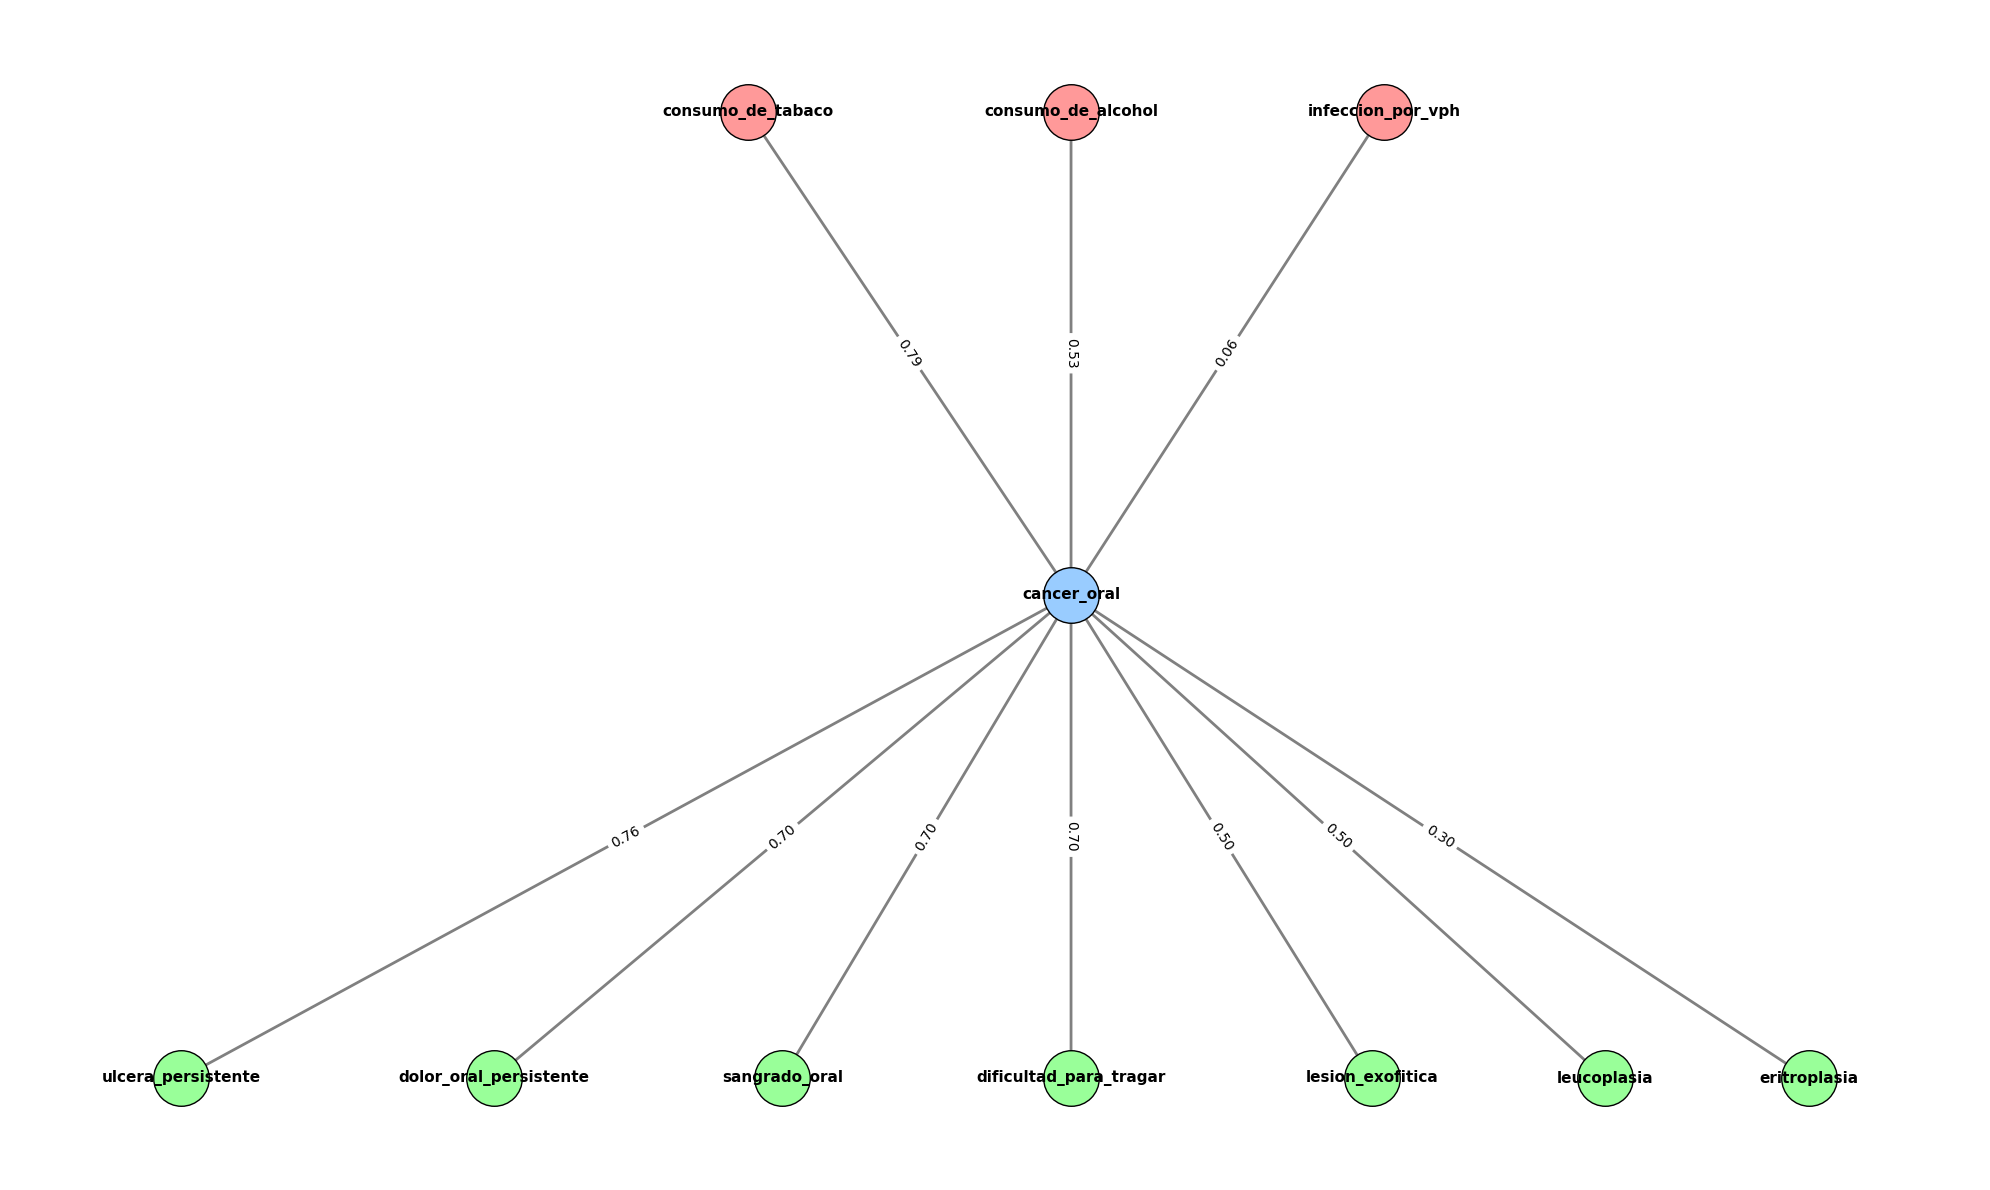

In [ ]:
visualizar_red_bayesiana(red_bayesiana, relaciones_prob)

Evaluación de paciente

In [ ]:
nodos_antecedentes = list(set(p for p, _ in relaciones_AC))
nodos_sintomas = list(set(s for _, s in relaciones_CS))
nodos_condiciones = list(set(c for _, c in relaciones_AC) | set(c for c, _ in relaciones_CS))

In [ ]:
for cpd in red_bayesiana.get_cpds():
    print(f"\nCPD de {cpd.variable}:")
    print(cpd)


CPD de consumo_de_tabaco:
+----------------------+-----+
| consumo_de_tabaco(0) | 0.5 |
+----------------------+-----+
| consumo_de_tabaco(1) | 0.5 |
+----------------------+-----+

CPD de cancer_oral:
+--------------------+-----+-----------------------+
| consumo_de_tabaco  | ... | consumo_de_tabaco(1)  |
+--------------------+-----+-----------------------+
| consumo_de_alcohol | ... | consumo_de_alcohol(1) |
+--------------------+-----+-----------------------+
| infeccion_por_vph  | ... | infeccion_por_vph(1)  |
+--------------------+-----+-----------------------+
| cancer_oral(0)     | ... | 0.09277800000000003   |
+--------------------+-----+-----------------------+
| cancer_oral(1)     | ... | 0.907222              |
+--------------------+-----+-----------------------+

CPD de consumo_de_alcohol:
+-----------------------+-----+
| consumo_de_alcohol(0) | 0.5 |
+-----------------------+-----+
| consumo_de_alcohol(1) | 0.5 |
+-----------------------+-----+

CPD de infeccion_por_vph:

In [ ]:
evaluar_paciente_desde_texto(red_bayesiana, vectorstore, nodos_antecedentes, nodos_sintomas, nodos_condiciones)

Ingrese el texto clínico del paciente (finalice con ENTER):
>> Paciente masculino de 56 años, con antecedentes de consumo crónico de tabaco y alcohol, además de infección previa por VPH. Consulta por úlcera persistente en borde lateral de lengua, de seis semanas de evolución, asociada a dolor oral continuo, sangrado ocasional y dificultad para la deglución.  Al examen se observa lesión exofítica de bordes irregulares, con áreas de leucoplasia y eritroplasia, e induración local. Dado el contexto clínico y los factores de riesgo, se sospecha carcinoma oral, por lo que se indica biopsia incisional y estudio histopatológico para confirmación diagnóstica.

                                     📊 RESULTADOS DE EVALUACIÓN                                     
El paciente presenta una probabilidad muy alta de cáncer oral, del 99.4%, influenciada por varios
factores de riesgo y síntomas. El consumo de tabaco y alcohol, ambos presentes, son los principales
contribuyentes al riesgo, con impactos de

In [ ]:
evaluar_paciente_desde_texto(red_bayesiana, vectorstore, nodos_antecedentes, nodos_sintomas, nodos_condiciones)

Ingrese el texto clínico del paciente (finalice con ENTER):
>> Paciente masculino de 49 años, fumador ocasional y consumidor social de alcohol. Consulta por placa blanca en mucosa yugal derecha, indolora y de tres semanas de evolución. A la exploración se observa leucoplasia homogénea de aproximadamente 1 cm, sin induración ni ulceración.

                                     📊 RESULTADOS DE EVALUACIÓN                                     
El paciente presenta una probabilidad del 90% de desarrollar cáncer oral, influenciada
significativamente por factores de riesgo como el consumo de tabaco y alcohol. El tabaquismo, con un
impacto del 18%, es el principal contribuyente, ya que el tabaco contiene carcinógenos que dañan el
ADN y promueven un ambiente proinflamatorio que favorece la progresión tumoral. El consumo de
alcohol, con un impacto del 5%, potencia el efecto carcinogénico del tabaco al aumentar la
permeabilidad de la mucosa oral y facilitar la penetración de carcinógenos. Además, 